In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Librarys

In [15]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(0)
tf.random.set_seed(42)


#  Read & Resize imegs

In [16]:

file_name = r"C:\Users\ZBook\Downloads\Data_Tumor"

X = []
y = []

yes_path = os.path.join(file_name, "yes")
for img_name in tqdm(os.listdir(yes_path)):
    img_path = os.path.join(yes_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(1)  

no_path = os.path.join(file_name, "no")
for img_name in tqdm(os.listdir(no_path)):
    img_path = os.path.join(no_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(0)  

X = np.array(X)
y = np.array(y)

print(f"Total images: {len(X)}, Total labels: {len(y)}")

100%|██████████| 98/98 [00:00<00:00, 488.36it/s]

Total images: 253, Total labels: 253


In [17]:
#normalization for X
X = X / 255.0 


In [18]:
# split Data to Train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


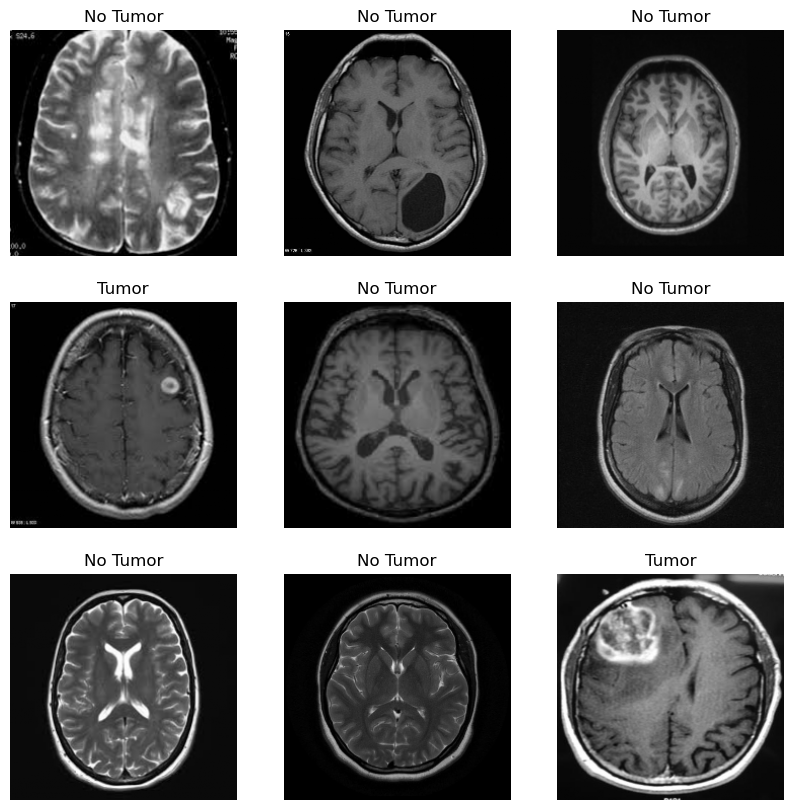

In [19]:
# Visualize the training dataset
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title("Tumor" if y_train[i] == 1 else "No Tumor")  
    plt.axis("off")
plt.show()

In [20]:

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)   

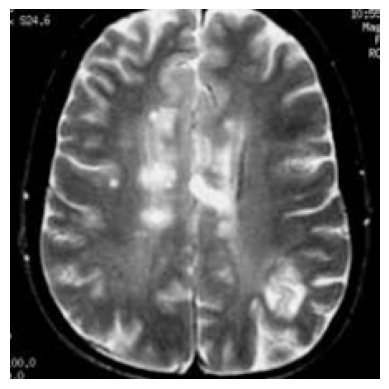

In [21]:
# Read Img From Training Data
plt.imshow((X_train[0] * 255).astype("uint8"))  
plt.axis("off")
plt.show()


In [22]:
from tensorflow.keras.utils import to_categorical

# Convert y_train and y_test to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Batches Of Data

In [23]:
# Split Data to Batchs
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32) 

# Data Augmentation

In [24]:
# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip(),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)

In [25]:
# Get the class names
class_names = np.unique(y_train)  
print(class_names)

[0. 1.]


# Show Augmentation effict

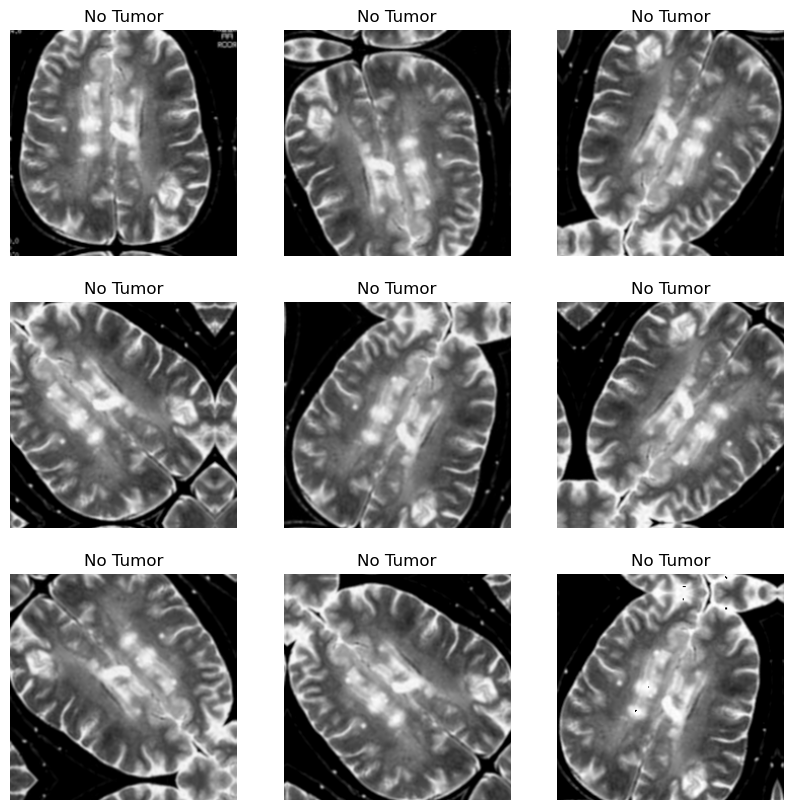

In [26]:
# View the augmentations
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))  
        plt.imshow((aug_img[0].numpy() * 255).astype("uint8"))  
        plt.title("Tumor" if np.argmax(labels[0].numpy()) == 1 else "No Tumor")  
        plt.axis("off")
plt.show()


# Bulid the Model

In [27]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224 


vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False
    
# print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    def lw(bottom_model, num_classes):
        """Creates the top or head of the model that will be 
        placed on top of the bottom layers"""

        top_model = bottom_model.output  
        top_model = GlobalAveragePooling2D()(top_model)  
        top_model = Dense(1024, activation='relu')(top_model)  
        top_model = Dense(1024, activation='relu')(top_model)  
        top_model = Dense(512, activation='relu')(top_model)   
        top_model = Dense(num_classes, activation='softmax')(top_model) 
    
        return top_model 


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


# Import necessary libraries

In [28]:

from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D


# Edit on VGG-16 Model

In [29]:
# Define the top layer of the model
def lw(bottom_model, num_classes):
    """Defines the top or head of the model"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)  
    top_model = Dense(1024, activation='relu')(top_model) 
    top_model = Dense(1024, activation='relu')(top_model)  
    top_model = Dense(512, activation='relu')(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)  
    return top_model

num_classes = 2

# Loa base VGG16 model without top layers
vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in VGG16
for layer in vgg.layers:
    layer.trainable = False

# Add top layer to the VGG16 model
FC_Head = lw(vgg, num_classes)

# final model by connecting VGG16 model and top layer
model = Model(inputs=vgg.input, outputs=FC_Head)
print(model.summary())



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [30]:
# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8)

# Compile & Train Model

In [31]:
EPOCHS=200

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, callbacks = [lr_callback, stop_callback],
                    epochs = EPOCHS, verbose = 1, validation_data=(X_test, y_test), initial_epoch=0)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5884 - loss: 0.7307 - val_accuracy: 0.6078 - val_loss: 0.7089 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.6293 - loss: 0.6809 - val_accuracy: 0.6667 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.6307 - loss: 0.5995 - val_accuracy: 0.7647 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.7491 - loss: 0.5454 - val_accuracy: 0.7843 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.7843 - loss: 0.4926 - val_accuracy: 0.8039 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.7941 - loss: 0.4433 - val_accuracy: 0.8039 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8270 - loss: 0.3903 - val_accuracy: 0.8235 

# Show Train & Validation Accuracy

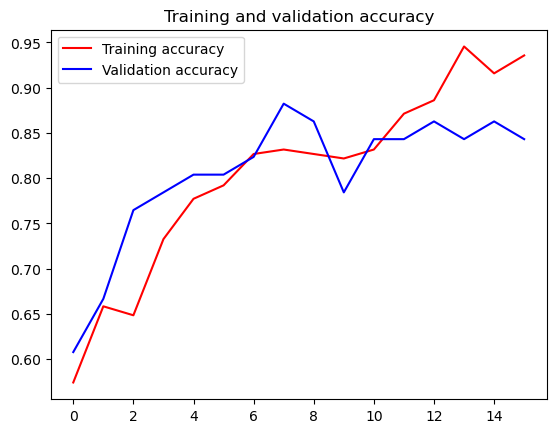

<Figure size 640x480 with 0 Axes>

In [32]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [33]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8329 - loss: 0.3221


[0.2960008680820465, 0.843137264251709]